### Make our Real and Fake DF

In [1]:
import os
import pandas as pd

def create_df_from_folders(real_path, fake_path):
    # Get list of files in each folder
    real_files = [os.path.join(real_path, f) for f in os.listdir(real_path) if os.path.isfile(os.path.join(real_path, f))]
    fake_files = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if os.path.isfile(os.path.join(fake_path, f))]

    # Create DataFrame
    df_real = pd.DataFrame(real_files, columns=['filepath'])
    df_real['label'] = 'REAL'

    df_fake = pd.DataFrame(fake_files, columns=['filepath'])
    df_fake['label'] = 'FAKE'

    # Combine both DataFrames
    df = pd.concat([df_real, df_fake], ignore_index=True)

    return df

real_path = './Image_DeepFake_Detector/REAL/'  
fake_path = './Image_DeepFake_Detector/FAKE/' 
df = create_df_from_folders(real_path, fake_path)
df

,filepath,label
0,./Image_DeepFake_Detector/REAL/pexels-photo-67...,REAL
1,./Image_DeepFake_Detector/REAL/pexels-photo-66...,REAL
2,./Image_DeepFake_Detector/REAL/pexels-photo-35...,REAL
3,./Image_DeepFake_Detector/REAL/pexels-photo-61...,REAL
4,./Image_DeepFake_Detector/REAL/pexels-photo-61...,REAL
...,...,...
464,./Image_DeepFake_Detector/FAKE/MTQ0MDIyLmpwZw.jpg,FAKE
465,./Image_DeepFake_Detector/FAKE/MjI2NzkzLmpwZw.jpg,FAKE
466,./Image_DeepFake_Detector/FAKE/OTMxOTQ5LmpwZw.jpg,FAKE
467,./Image_DeepFake_Detector/FAKE/NTYyOTAxLmpwZw.jpg,FAKE


## I want to balance the data set- so I'll check the length of each and cut some out

In [2]:
real_count = df[df['label'] == 'REAL'].shape[0]
fake_count = df[df['label'] == 'FAKE'].shape[0]

print(f"Number of REAL images: {real_count}")
print(f"Number of FAKE images: {fake_count}")

Number of REAL images: 120
Number of FAKE images: 349


In [6]:
# Filter out the REAL and FAKE datasets separately
df_real = df[df['label'] == 'REAL']
df_fake = df[df['label'] == 'FAKE']

# Randomly sample 120 images from the FAKE dataset
df_fake_sampled = df_fake.sample(n=120, random_state=42)  # random_state for reproducibility

# Combine the REAL dataset with the sampled FAKE dataset
balanced_df = pd.concat([df_real, df_fake_sampled], ignore_index=True)

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the balance
print("Number of REAL images:", balanced_df[balanced_df['label'] == 'REAL'].shape[0])
print("Number of FAKE images:", balanced_df[balanced_df['label'] == 'FAKE'].shape[0])


Number of REAL images: 120
Number of FAKE images: 120


## Now that we are balanced, I want to preprocess the images.

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters (can be adjusted)
img_width, img_height = 128, 128  # Size to which images will be resized
batch_size = 32  # Number of images processed at a time

# Splitting the DataFrame into a training set and a validation set
train_df, val_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

# ImageDataGenerator for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation data

# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # For binary classification
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)


2024-01-10 13:03:10.662875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 192 validated image filenames belonging to 2 classes.
Found 48 validated image filenames belonging to 2 classes.


/Users/abdulrahmanamer/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


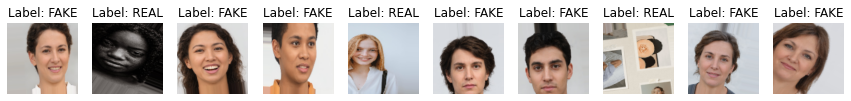

In [15]:
import matplotlib.pyplot as plt

# Retrieve a batch of images from the train generator
x_batch, y_batch = next(train_generator)

# Define number of images to show
num_images = 10

plt.figure(figsize=(15, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(x_batch[i])
    plt.title('Label: {}'.format('REAL' if y_batch[i]==1 else 'FAKE'))
    plt.axis('off')
plt.show()

## Model 1

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model configuration
input_shape = (img_width, img_height, 3)  # 3 channels for RGB images
num_classes = 2  # REAL and FAKE

# Building the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Number of epochs can be adjusted
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)



2024-01-10 13:05:37.731814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/Users/abdulrahmanamer/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6/6 [==============================] - 7s 1s/step - loss: 1.4375 - accuracy: 0.5469 - val_loss: 0.6196 - val_accuracy: 0.7917
Epoch 2/10
6/6 [==============================] - 6s 1s/step - loss: 0.6208 - accuracy: 0.6667 - val_loss: 0.4944 - val_accuracy: 0.8542
Epoch 3/10
6/6 [==============================] - 6s 984ms/step - loss: 0.5241 - accuracy: 0.7448 - val_loss: 0.3850 - val_accuracy: 0.8542
Epoch 4/10
6/6 [==============================] - 6s 956ms/step - loss: 0.4278 - accuracy: 0.8385 - val_loss: 0.2647 - val_accuracy: 0.9167
Epoch 5/10
6/6 [==============================] - 6s 981ms/step - loss: 0.3471 - accuracy: 0.8698 - val_loss: 0.1836 - val_accuracy: 0.9583
Epoch 6/10
6/6 [==============================] - 6s 989ms/step - loss: 0.3984 - accuracy: 0.8281 - val_loss: 0.4190 - val_accuracy: 0.8333
Epoch 7/10
6/6 [==============================] - 6s 999ms/step - loss: 0.3932 - accuracy: 0.8125 - val_loss: 0.2526 - val_accuracy: 0.9167
Epoch 8/10
6/6 [=====================

1/1 [==============================] - 0s 126ms/step


/Users/abdulrahmanamer/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


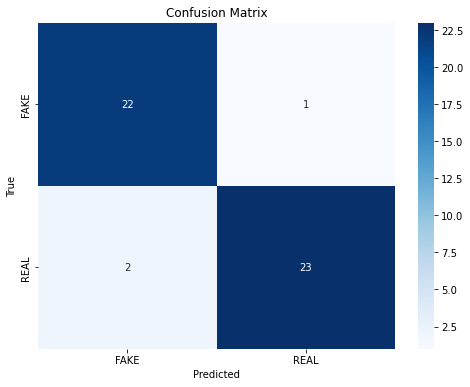

In [25]:
# Calculate the total number of batches in the validation generator
total_batches = np.ceil(len(validation_generator.filenames) / validation_generator.batch_size)

# Initialize lists to store true labels and predictions
all_val_labels = []
all_predictions = []

# Iterate over all batches and accumulate labels and predictions
for _ in range(int(total_batches)):
    val_images, val_labels = next(validation_generator)
    predictions = model.predict(val_images)
    all_val_labels.extend(val_labels)
    all_predictions.extend(predictions)

# Binarize predictions
all_predictions = np.round(all_predictions).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(all_val_labels, all_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Model 2 let's try a resnet model to see if can beat the original 

In [16]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Create the final model
resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
resnet.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = resnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

94765736/94765736 [==============================] - 9s 0us/step


/Users/abdulrahmanamer/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
6/6 [==============================] - 11s 1s/step - loss: 0.7343 - accuracy: 0.5052 - val_loss: 0.6952 - val_accuracy: 0.4792
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 0.7054 - accuracy: 0.5000 - val_loss: 0.6879 - val_accuracy: 0.5208
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 0.7068 - accuracy: 0.4948 - val_loss: 0.6751 - val_accuracy: 0.5208
Epoch 4/10
6/6 [==============================] - 8s 1s/step - loss: 0.6859 - accuracy: 0.5625 - val_loss: 0.6686 - val_accuracy: 0.5833
Epoch 5/10
6/6 [==============================] - 8s 1s/step - loss: 0.6813 - accuracy: 0.5104 - val_loss: 0.6730 - val_accuracy: 0.4792
Epoch 6/10
6/6 [==============================] - 8s 1s/step - loss: 0.6814 - accuracy: 0.5052 - val_loss: 0.6600 - val_accuracy: 0.5000
Epoch 7/10
6/6 [==============================] - 8s 1s/step - loss: 0.6714 - accuracy: 0.5990 - val_loss: 0.6462 - val_accuracy: 0.8958
Epoch 8/10
6/6 [========================

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/Users/abdulrahmanamer/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 1s 909ms/step


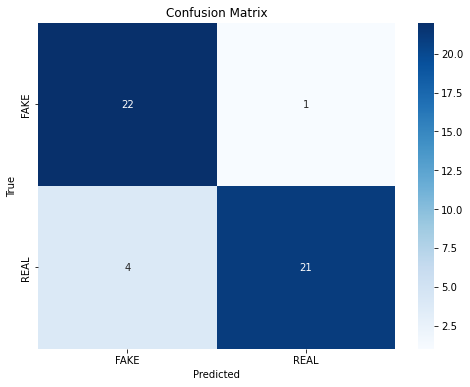

In [24]:
# Calculate the total number of batches in the validation generator
total_batches = np.ceil(len(validation_generator.filenames) / validation_generator.batch_size)

# Initialize lists to store true labels and predictions
all_val_labels = []
all_predictions = []

# Iterate over all batches and accumulate labels and predictions
for _ in range(int(total_batches)):
    val_images, val_labels = next(validation_generator)
    predictions = resnet.predict(val_images)
    all_val_labels.extend(val_labels)
    all_predictions.extend(predictions)

# Binarize predictions
all_predictions = np.round(all_predictions).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(all_val_labels, all_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# VGG16 Model

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model
base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for binary classification
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
vvg = Model(inputs=base.input, outputs=predictions)

# Compile the model
vvg.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = vvg.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # This is one of the hyperparameters you can tune
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

/Users/abdulrahmanamer/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/Users/abdulrahmanamer/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
6/6 [==============================] - 30s 5s/step - loss: 0.7188 - accuracy: 0.5208 - val_loss: 0.5889 - val_accuracy: 0.9375
Epoch 2/10
6/6 [==============================] - 29s 5s/step - loss: 0.5402 - accuracy: 0.7396 - val_loss: 0.2008 - val_accuracy: 0.9792
Epoch 3/10
6/6 [==============================] - 29s 5s/step - loss: 0.2823 - accuracy: 0.8854 - val_loss: 0.2451 - val_accuracy: 0.9167
Epoch 4/10
6/6 [==============================] - 26s 4s/step - loss: 0.1847 - accuracy: 0.9167 - val_loss: 0.0654 - val_accuracy: 0.9792
Epoch 5/10
6/6 [==============================] - 26s 4s/step - loss: 0.1839 - accuracy: 0.9219 - val_loss: 0.0278 - val_accuracy: 0.9792
Epoch 6/10
6/6 [==============================] - 30s 5s/step - loss: 0.0823 - accuracy: 0.9792 - val_loss: 0.0227 - val_accuracy: 0.9792
Epoch 7/10
6/6 [==============================] - 30s 5s/step - loss: 0.0268 - accuracy: 0.9896 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 8/10
6/6 [==================

## Best Performer was #VGG16 Catching all of the images!

1/1 [==============================] - 0s 478ms/step


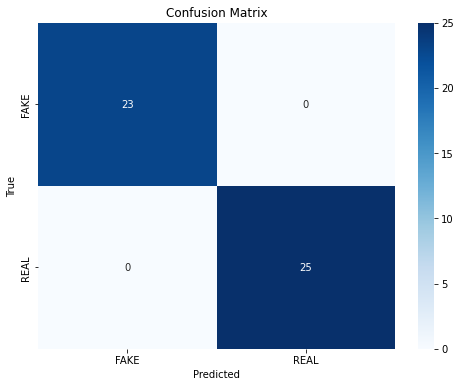

In [23]:
# Calculate the total number of batches in the validation generator
total_batches = np.ceil(len(validation_generator.filenames) / validation_generator.batch_size)

# Initialize lists to store true labels and predictions
all_val_labels = []
all_predictions = []

# Iterate over all batches and accumulate labels and predictions
for _ in range(int(total_batches)):
    val_images, val_labels = next(validation_generator)
    predictions = vvg.predict(val_images)
    all_val_labels.extend(val_labels)
    all_predictions.extend(predictions)

# Binarize predictions
all_predictions = np.round(all_predictions).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(all_val_labels, all_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()